# 第4章: 形態素解析
夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](https://nlp100.github.io/data/neko.txt)）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39は[matplotlib](http://matplotlib.org/)もしくは[Gnuplot](http://www.gnuplot.info/)を用いるとよい．

In [1]:
# 小説内の文章を解析するので、新語辞書ではなくデフォルト辞書を明示的に指定
!mecab -o neko.txt.mecab neko.txt -d /var/lib/mecab/dic/debian

## 30. 形態素解析結果の読み込み
形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [2]:
def load_analyzed_results():
    analyzed_results = [] # 文章全体の形態素解析結果
    morphemes = [] # 1文単位の形態素解析結果
    with open('neko.txt.mecab', 'r', encoding='utf8') as f:
        for analyzed_result in f:
            if analyzed_result == 'EOS\n':
                # 文末: その1文の形態素解析結果を丸ごと記録
                analyzed_results.append(morphemes)
                morphemes = []
                continue
            
            analyzed_detail = analyzed_result.split('\t')
            if analyzed_detail[0] in ('', '\n'):
                # 解析対象が空文字や改行文字 ... スキップ
                continue
            
            feature = analyzed_detail[1].split(',')
            morpheme = {
                'surface': analyzed_detail[0],
                'base': feature[6],
                'pos': feature[0],
                'pos1': feature[1]
            }
            # 文中: 1文単位のリストに、形態素解析結果を記録
            morphemes.append(morpheme)
    return analyzed_results


## 31. 動詞
動詞の表層形をすべて抽出せよ．

In [3]:
analyzed_results = load_analyzed_results()
verb_surfaces = {
    morpheme['surface'] \
    for analyzed_sentence in analyzed_results \
    for morpheme in analyzed_sentence \
    if morpheme['pos'] == '動詞'
}

print('num: {}'.format(len(verb_surfaces)))
for surface in list(verb_surfaces)[:10]:
    print(surface)

with open('output/q31.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(verb_surfaces))

num: 3893
召し上がら
癒す
入り込ん
取り極め
放し
上ら
思いつい
扱が
試みよ
許さ


## 32. 動詞の原形
動詞の原形をすべて抽出せよ．

In [4]:
analyzed_results = load_analyzed_results()
verb_bases = {
    morpheme['base'] \
    for analyzed_sentence in analyzed_results \
    for morpheme in analyzed_sentence \
    if morpheme['pos'] == '動詞'
}

print('num: {}'.format(len(verb_bases)))
for base in list(verb_bases)[:10]:
    print(base)

with open('output/q32.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(verb_bases))

num: 2300
縛り付ける
癒す
はぐる
仰せる
聞き糺す
叩き上げる
凋む
砕ける
まう
娶る


## 33. 「AのB」
2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [5]:
analyzed_results = load_analyzed_results()
noun_clauses = {
    analyzed_sentence[i - 1]['surface'] + analyzed_sentence[i]['surface'] + analyzed_sentence[i + 1]['surface'] \
    for analyzed_sentence in analyzed_results \
    for i in range(1, len(analyzed_sentence) -1) \
    if analyzed_sentence[i - 1]['pos'] == '名詞' \
    and analyzed_sentence[i]['surface'] == 'の' \
    and analyzed_sentence[i + 1]['pos'] == '名詞'
}

print('num: {}'.format(len(noun_clauses)))
for noun_clause in list(noun_clauses)[:10]:
    print(noun_clause)

with open('output/q33.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(verb_bases))

num: 4924
さの三
近くの生徒
尊敬の度
夫婦の関係
自分の勝手
主客の対話
何の苦
坊主の寝言
本の上
登場の人物


## 34. 名詞の連接
名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [6]:
analyzed_results = load_analyzed_results()
successive_nouns = set()
for analyzed_sentence in analyzed_results:
    successive_noun = ''
    connected_num = 0
    for morpheme in analyzed_sentence:
        if morpheme['pos'] == '名詞':
            successive_noun += morpheme['surface']
            connected_num += 1
        elif connected_num >= 2:
            successive_nouns.add(successive_noun)
            successive_noun = ''
            connected_num = 0
        else:
            successive_noun = ''
            connected_num = 0

print('num: {}'.format(len(successive_nouns)))
for successive_noun in list(successive_nouns)[:10]:
    print(successive_noun)

with open('output/q34.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(successive_nouns))

num: 4454
一たび流し
談判不調
芋坂
吾輩ひそか
西洋手拭
天然居士噫
夏さん
御座候本書
金田令夫人
八十


## 35. 単語の出現頻度
文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [7]:
def extract_words_frequency():
    analyzed_results = load_analyzed_results()
    words_counter = {}
    for analyzed_sentence in analyzed_results:
        for morpheme in analyzed_sentence:
            if morpheme['surface'] in words_counter.keys():
                words_counter[morpheme['surface']] += 1
            else:
                words_counter[morpheme['surface']] = 1
    return sorted(words_counter.items(), key=lambda x: x[1], reverse=True)

final_counter = extract_words_frequency()
for k, v in final_counter[:10]:
    print(k, v)

# ファイル出力用にリスト内を整形してから、ファイル出力
final_counter = ['{}\t{}'.format(elm[0], elm[1]) for elm in final_counter]
with open('output/q35.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(final_counter))

の 9194
。 7486
て 6868
、 6772
は 6420
に 6243
を 6071
と 5508
が 5337
た 3988


## 36. 頻度上位10語
出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

findfont: Font family ['MigMix 1P'] not found. Falling back to DejaVu Sans.


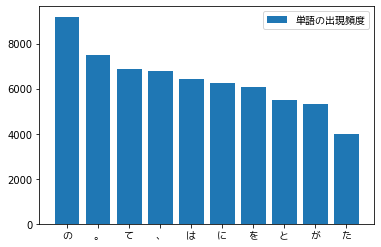

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

top10_frequency_words = extract_words_frequency()[:10]
x = [word[0] for word in top10_frequency_words] # 出現頻度が高い10語
y = [word[1] for word in top10_frequency_words] # 各単語の出現頻度

# Matplotlibで日本語を使うためのフォント設定
font_path = '/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

plt.bar(np.array(x), np.array(y), label='単語の出現頻度')
plt.xticks(x, x, fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.savefig('output/q36.png')

## 37. 「猫」と共起頻度の高い上位10語
「猫」とよく共起する（共起頻度が高い）10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

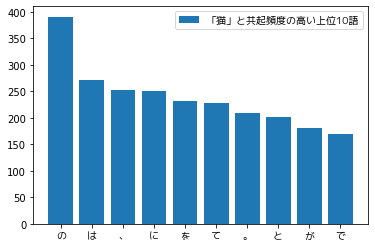

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def extract_co_occurrence_cat_frequency():
    analyzed_results = load_analyzed_results()
    co_occurrence_cat_counter = {}
    for analyzed_sentence in analyzed_results:
        if '猫' in [morpheme['surface'] for morpheme in analyzed_sentence]:
            for morpheme in analyzed_sentence:
                if morpheme['surface'] in co_occurrence_cat_counter.keys():
                    co_occurrence_cat_counter[morpheme['surface']] += 1
                else:
                    co_occurrence_cat_counter[morpheme['surface']] = 1
    del co_occurrence_cat_counter['猫']
    return sorted(co_occurrence_cat_counter.items(), key=lambda x: x[1], reverse=True)

top10_co_occurrence_frequency_cat = extract_co_occurrence_cat_frequency()[:10]
x = [word[0] for word in top10_co_occurrence_frequency_cat] # 出現頻度が高い10語
y = [word[1] for word in top10_co_occurrence_frequency_cat] # 各単語の出現頻度

# Matplotlibで日本語を使うためのフォント設定
font_path = '/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

plt.bar(np.array(x), np.array(y), label='「猫」と共起頻度の高い上位10語')
plt.xticks(x, x, fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.savefig('output/q37.png')

## 38. ヒストグラム
単語の出現頻度のヒストグラムを描け．ただし，横軸は出現頻度を表し，1から単語の出現頻度の最大値までの線形目盛とする．縦軸はx軸で示される出現頻度となった単語の異なり数（種類数）である．

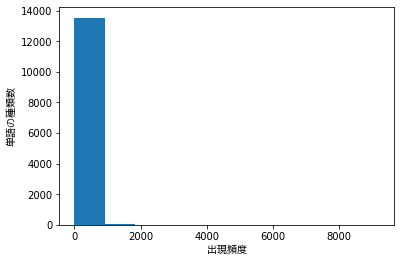

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Matplotlibで日本語を使うためのフォント設定
font_path = '/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

x = [word[1] for word in extract_words_frequency()]
plt.hist(x)
plt.xlabel('出現頻度', fontproperties=font_prop)
plt.ylabel('単語の種類数', fontproperties=font_prop)
plt.savefig('output/q38.png')

## 39. Zipfの法則
単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

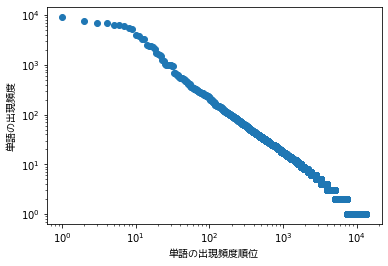

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Matplotlibで日本語を使うためのフォント設定
font_path = '/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

occurrence_frequencies = [word[1] for word in extract_words_frequency()]
ranks = range(1, len(occurrence_frequencies) + 1)

plt.scatter(ranks, occurrence_frequencies)
# x軸, y軸共にlogスケールに設定 -> 両対数グラフ
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('単語の出現頻度順位', fontproperties=font_prop)
plt.ylabel('単語の出現頻度', fontproperties=font_prop)

plt.savefig('output/q39.png')